In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

import pandas as pd
import numpy as np

import pulp

from src.utils import show_preferences,show_rank,verify_preferences,flip_rank,show_domination,find_dominated_alternatives
from src.promethee import Promethee2

from typing import Optional, List,Tuple,Dict,Any,Hashable
from dataclasses import dataclass,field
from queue import PriorityQueue

# Phone Ranking Problem using UTA and AHP

Łukasz Andryszewski 151930

Choosing a new phone is often quite a daunting task, with many different models from different companies and varying prices.

In [2]:
data = pd.read_csv("./data/dataset.csv").set_index("name")
prefs = pd.read_csv("./data/preferences.csv")

In [3]:
data

,price-cost,ram-gain,screen-gain,disk-gain,oled-gain,os-gain,foldable-gain
name,,,,,,,
Huawei P30,1699,6.000,6.10,128,1,3,0
Huawei P20 Lite,899,4.000,5.80,64,0,3,0
Iphone 15,4699,6.000,6.70,128,1,0,0
Iphone 12,2499,4.000,6.10,64,1,0,0
Motorola Razr Ultra,3999,8.000,6.90,256,1,3,1
Motorola Razr 40,2999,8.000,6.90,256,1,3,1
Samsung Galaxy Z Flip 5,5599,8.000,6.70,256,1,3,1
Motorola Razr 8,2657,8.000,6.67,256,1,3,1
Nokia 2660 Flip,299,4.000,2.80,128,1,1,1


In [4]:
crit_types = [True if crit.split("-")[1]=="gain" else False for crit in data.columns ]
crit_types

[False, True, True, True, True, True, True]

In [5]:
data.columns = list(map(lambda s: s.split("-")[0],data.columns))

##### Cost criteria
Price criteria comes from one of the various online offers for a given alternative. It is continous, its range is from 100 up to 5599. It is the only cost criterion

##### Gain criteria

Ram, screen and disk are some parameters of the phones. 

Ram is continuous - from 0.004 to 12

Screen is continuous - from 1.7 to 6.9

Disk is continuous - from 16 to 512

Oled and foldable are binary and describe if the phone has an oled screen and if it is foldable. Both of these features are desired to have, with 0 representing their absence and 1 representing their presence.

OS is a criterion evaluated by the decision maker, which signifies which os the phone uses:

- 0 - Iphone
- 1 - Misc.
- 2 - Harmony OS
- 3 - Android

In [6]:
prefs

,id,preferred_to
0,0,1
1,4,6
2,8,11
3,3,2
4,3,9


In [7]:
show_preferences(prefs,data.index)

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Iphone 12 is preferred to Huawei P40


There exist alternatives that are dominated by others.

In [8]:
show_domination(find_dominated_alternatives(data,crit_types),data.index)

i dominates:
Huawei P30 > 
Huawei P20 Lite > 
Iphone 15 > 
Iphone 12 > 
Motorola Razr Ultra > Iphone 15
Motorola Razr 40 > Iphone 15, Motorola Razr Ultra
Samsung Galaxy Z Flip 5 > 
Motorola Razr 8 > 
Nokia 2660 Flip > 
Huawei P40 > Iphone 12
Samsung Galaxy A55 > Iphone 12
Nokia 3310 > 
Samsung Galaxy M34 > Huawei P30, Iphone 12
Xiaomi Poco X6 Pro > Huawei P30, Iphone 12, Huawei P40, Samsung Galaxy A55
Lg V60 > Huawei P30, Iphone 15, Iphone 12


## UTA method

In this section UTA value functions are defined and later used for linear problems optimization using the pulp library.

In [9]:
@dataclass(order=True)
class BreakPoint:
	x: float
	y: pulp.LpVariable=field(compare=False)

	def __getitem__(self,key):
		if key == 0:
			return self.x
		elif key == 1:
			return self.y
		else:
			raise IndexError("Not a valid key '{}'".format(key))

In [10]:
class ValueFunction:
	def __init__(self,*args,**kwds):
		self.breakpoints = []
		for (i,j) in args:
			self.breakpoints.append(BreakPoint(i,j))
		
		self.breakpoints.sort()
		
		self.isGain = kwds["isGain"] if "isGain" in kwds else True
		self.name = kwds["name"] if "name" in kwds else None

	def __call__(self, *args: Any, **kwds: Any) -> Any:
		x = args[0]
		previous_breakpoint = None
		for break_point in self.breakpoints:
			if (x <= break_point.x): 
				break
			previous_breakpoint = break_point

		x2,y2 = break_point
		if previous_breakpoint != None:
			x1,y1 = previous_breakpoint

		if previous_breakpoint != None and previous_breakpoint != break_point:
			return (((x-x1)/(x2-x1)) * (y2-y1)) + y1 
		else: 
			return y2
	
	def __iadd__(self,xy):
		x,y = xy
		self.breakpoints.append(BreakPoint(x,y))
		self.breakpoints.sort()
		return self
	
	def __getitem__(self,key):
		if key < len(self.breakpoints):
			return self.breakpoints[key]
		else:
			return IndexError("Not a valid key '{}'".format(key))
		
	def __iter__(self):
		for b in self.breakpoints:
			yield b

		
	def __len__(self):
		return len(self.breakpoints)

	def marginal_worst(self):
		return self.breakpoints[0] if self.isGain else self.breakpoints[-1]
	
	def marginal_best(self):
		return self.breakpoints[-1] if self.isGain else self.breakpoints[0]

	def draw(self,scaled=False):
		x = np.array([break_point.x for break_point in self.breakpoints])
		if scaled:
			x -= x[0]
			x /= x[-1]
		y = [break_point.y.varValue for break_point in self.breakpoints]
		plt.ylabel("Criteria weight")
		plt.plot(x,y,label=self.name if self.name != None else "line")

	def plot(self):
		# x1,y1 = self.breakpoints[0]
		# x2,y2 = self.breakpoints[-1]
		# x = np.arange(x1,x2+1,1)
		# y = [self(x_i) for x_i in x]
		self.draw()
		plt.xlabel("Criteria value")
		plt.title(self.name if self.name != None else "Criteria")
		plt.show()


In [11]:
class AdditiveValueFunction:
	def __init__(self,u_funcs:List[ValueFunction]):
		self.u_funcs = u_funcs
		#self.__weight_sum = np.sum(weights)

	def __getitem__(self,key):
		if key < len(self.u_funcs):
			return self.u_funcs[key]
		else:
			return IndexError("Not a valid key '{}'".format(key))
	
	def __iter__(self):
		for u in self.u_funcs:
			yield u

	def __call__(self,*alt,**kwds):
		return sum([self.u_funcs[i](crit) for i,crit in enumerate(alt)])
		#return sum((self.weights*values)/self.__weight_sum)
	
	def plot(self):
		for u in self:
			u.draw(True)
		plt.legend()
		plt.xlabel("Scaled criteria values")
		plt.title("U functions")
		plt.show()


In [12]:
def create_U(data:pd.DataFrame,crit_types:List[bool],breakpoints=3):
	assert breakpoints >= 2
	u_max = 1/len(data.columns)
	u_funcs = []
	for crit_i,column_name in enumerate(data):
		column = data[column_name]
		_min = min(column)
		_max = max(column)

		_range = _max-_min
		_steps = _range/(breakpoints-1)

		breaks = [_min] + [_min + (_steps*(b+1)) for b in range(breakpoints-2)] + [_max]

		u = ValueFunction(isGain = crit_types[crit_i],name=column_name)
		for b in breaks:
			var = pulp.LpVariable(f"{column_name}_{b}",lowBound=0,upBound=1)
			u += (b,var)
		u_funcs.append(u)

		# best,worst = _max,_min
		# if not crit_types[crit_i]:
		# 	best,worst = worst,best
		# first,last = pulp.LpVariable(f"{column_name}_worst",lowBound=0,upBound=1),pulp.LpVariable(f"{column_name}_best",lowBound=0,upBound=1)
		# u_funcs.append(ValueFunction((worst,first),(best,last),isGain=crit_types[crit_i]))

		
	return AdditiveValueFunction(u_funcs)

In [13]:
U = create_U(data,crit_types,4)

In [14]:
def standard_criteria(U:AdditiveValueFunction,data:pd.DataFrame,min_thresh=0.05,max_thresh=0.5,prob_name="UTA method",prob_type=pulp.LpMaximize):

    crits = data.columns

    # Create LP problem
    prob = pulp.LpProblem(prob_name, prob_type)

    # Monotoncity criteria
    for j,u in enumerate(U):
        for i in range(len(u)-1):
            prob += u[i].y <= u[i+1].y if u.isGain else u[i].y >= u[i+1].y, f"monotonicity_{crits[j]}_{i}"

    # Normalization constraints for criteria
    for i,u in enumerate(U):
        prob += u.marginal_worst().y == 0, f"lowest_value_{crits[i]}"

    # min and max weights
    for i,u in enumerate(U):
        prob += u.marginal_best().y <= max_thresh, f"max_weight_{crits[i]}"
        prob += u.marginal_best().y >= min_thresh, f"min_weight_{crits[i]}"

    # norm of sum 
    prob += pulp.lpSum([u.marginal_best().y for u in U]) == 1, "norm_to_1"

    return prob

### Maximal subset of consitent preferences

In this section the algorithm find the minimal subset of pairwise comparisons that need to be removed, as they are inconsistent with eachother and data.

Here the preferences from the previous project are enriched with additional constraints. 

In [15]:
add_prefs = prefs.copy()
# inconsistent preferences
add_prefs.loc[len(add_prefs.index)] = [5,4] 
add_prefs.loc[len(add_prefs.index)] = [4,7]
add_prefs.loc[len(add_prefs.index)] = [7,5]

show_preferences(add_prefs,data.index)

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Iphone 12 is preferred to Huawei P40
Motorola Razr 40 is preferred to Motorola Razr Ultra
Motorola Razr Ultra is preferred to Motorola Razr 8
Motorola Razr 8 is preferred to Motorola Razr 40


The minimal subset of constraints to be removed is found by solving a linear programming problem, which includes binary variables which represent the comparisons. The problem is built upon the UTA method.

In [16]:
def minimal_subset(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction,equals:pd.DataFrame=None,with_vars=False):
	problem = standard_criteria(U,data,prob_name="minimal_subset",prob_type=pulp.LpMinimize)#pulp.LpProblem("minimal_subset")

	variables = dict([((i,j),pulp.LpVariable(f"v_{i}_{j}",cat=pulp.LpBinary)) for i,j in zip(prefs["id"],prefs["preferred_to"])])
	
	# objective function
	problem += pulp.lpSum([var for var in variables.values()])

	# preferences
	eps = 0.0001
	for (i,j),var in variables.items():
		alt_i,alt_j = data.iloc[i],data.iloc[j]
		problem += (U(*alt_i) >= U(*alt_j) - var + eps),f"{i}_preferred_to_{j}"

	return (problem) if not with_vars else (problem,variables)

In [17]:
minimal_subset(data,add_prefs,U)

minimal_subset:
MINIMIZE
1*v_0_1 + 1*v_3_2 + 1*v_3_9 + 1*v_4_6 + 1*v_4_7 + 1*v_5_4 + 1*v_7_5 + 1*v_8_11 + 0
SUBJECT TO
monotonicity_price_0: price_100 - price_1933.0 >= 0

monotonicity_price_1: price_1933.0 - price_3766.0 >= 0

monotonicity_price_2: price_3766.0 - price_5599 >= 0

monotonicity_ram_0: ram_0.004 - ram_4.002666666666666 <= 0

monotonicity_ram_1: ram_4.002666666666666 - ram_8.001333333333333 <= 0

monotonicity_ram_2: - ram_12.0 + ram_8.001333333333333 <= 0

monotonicity_screen_0: screen_1.7 - screen_3.4333333333333336 <= 0

monotonicity_screen_1: screen_3.4333333333333336 - screen_5.166666666666667
 <= 0

monotonicity_screen_2: screen_5.166666666666667 - screen_6.9 <= 0

monotonicity_disk_0: disk_16 - disk_181.33333333333334 <= 0

monotonicity_disk_1: disk_181.33333333333334 - disk_346.6666666666667 <= 0

monotonicity_disk_2: disk_346.6666666666667 - disk_512 <= 0

monotonicity_oled_0: oled_0 - oled_0.3333333333333333 <= 0

monotonicity_oled_1: oled_0.3333333333333333 - ol

To find all subsets of constitent criteria, an additional constraint is added that the sum of the variables from the previous minimal set must be smaller of equal then their size - 1. This is to ensure that and identical set is not indicated again.

In [18]:
def find_largest_consistent_set(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction):

    inconsistent = []
    consistent = []
    problem,variables = minimal_subset(data,prefs,U,with_vars=True)
    while True:
        if len(inconsistent) != 0:
            size = len(inconsistent[-1])
            problem += pulp.lpSum([variables[pair] for pair in inconsistent[-1]]) <= size-1

        problem.solve()
        consist_subset = []
        inconsist_subset = []
        for v in problem.variables():
            name = v.name.split("_")
            if name[0] != "v":
                continue
            if v.varValue == 1.0:
                inconsist_subset.append(tuple(map(int,(name[1],name[2]))))
            elif v.varValue == 0.0:
                consist_subset.append(tuple(map(int,(name[1],name[2]))))
        if problem.status == -1:
            return inconsistent,consistent
        inconsistent.append(inconsist_subset)
        consistent.append(consist_subset)

In [19]:
inconsist,consist = find_largest_consistent_set(data,add_prefs,U)
inconsist

[[(3, 9), (4, 7)], [(3, 9), (7, 5)]]

All consistent subsets of pairwise comparisons are:

In [20]:
print(*consist,sep="\n\n")

[(0, 1), (3, 2), (4, 6), (5, 4), (7, 5), (8, 11)]

[(0, 1), (3, 2), (4, 6), (4, 7), (5, 4), (8, 11)]


Predictably one of the comparisons from the inconsistent chain was deleted. 5 preferred to 4 cannot be deleted as 5 dominates 4 so no matter the values, U(5) is always higher than U(4) without breaking the UTA constraints.

3 preferred to 9 has to be deleted, as 3 is dominated by 9.

All found sets are of the same size so either of them can be removed.

In [21]:
def remove_prefs(prefs,vals):
    new_prefs = prefs.copy()
    for i,j in vals:
        new_prefs = new_prefs.drop(new_prefs[(new_prefs["id"]==i) & (new_prefs["preferred_to"]==j)].index)
    return new_prefs

In [22]:
reduced_prefs = remove_prefs(add_prefs,inconsist[-1])
show_preferences(reduced_prefs,data.index)

Huawei P30 is preferred to Huawei P20 Lite
Motorola Razr Ultra is preferred to Samsung Galaxy Z Flip 5
Nokia 2660 Flip is preferred to Nokia 3310
Iphone 12 is preferred to Iphone 15
Motorola Razr 40 is preferred to Motorola Razr Ultra
Motorola Razr Ultra is preferred to Motorola Razr 8


### 2.2 Ordinal Regression

In this section an UTA function is determined that satisfies the pairwise comparisons constraints. The problem minimizes the sum of over and under estimation errors of U values of each criterion. If no such UTA function exists the value of the objective function will be different than 0. This could indicate inconsistent criteria or too few number of breakpoints.

In [23]:
def ordinal_regression(data:pd.DataFrame,prefs:pd.DataFrame,U:AdditiveValueFunction):

	problem = standard_criteria(U,data,prob_name="ordinal_regression",prob_type=pulp.LpMinimize)#pulp.LpProblem("ordinal_regression")

	over_estimates = [pulp.LpVariable(f"over_{i}",cat=pulp.LpContinuous,lowBound=0) for i in range(len(data))]
	under_estimates = [pulp.LpVariable(f"under_{i}",cat=pulp.LpContinuous,lowBound=0) for i in range(len(data))]
	
	# objective function
	problem += pulp.lpSum([var for var in over_estimates] + [var for var in under_estimates])	

	# preferences
	eps = 0.0001 # epsilon for modelling sharp inequalities	
	for i,j in map(list,prefs.iloc):
		alt_i,alt_j = data.iloc[i],data.iloc[j]
		problem += (U(*alt_i) - over_estimates[i] + under_estimates[i] >= U(*alt_j) - over_estimates[j] + under_estimates[j] + eps), f"{i}_>_{j}"

	return problem

In [24]:
def solve_problem(problem):
    problem.solve()
    print("Status:", pulp.LpStatus[problem.status])
    print("Optimal Solution:")
    for v in problem.variables():
        print(v.name, "=", v.varValue)
    print("Optimal Objective Value:", pulp.value(problem.objective))

In [25]:
problem = ordinal_regression(data,reduced_prefs,U)
problem

ordinal_regression:
MINIMIZE
1*over_0 + 1*over_1 + 1*over_10 + 1*over_11 + 1*over_12 + 1*over_13 + 1*over_14 + 1*over_2 + 1*over_3 + 1*over_4 + 1*over_5 + 1*over_6 + 1*over_7 + 1*over_8 + 1*over_9 + 1*under_0 + 1*under_1 + 1*under_10 + 1*under_11 + 1*under_12 + 1*under_13 + 1*under_14 + 1*under_2 + 1*under_3 + 1*under_4 + 1*under_5 + 1*under_6 + 1*under_7 + 1*under_8 + 1*under_9 + 0
SUBJECT TO
monotonicity_price_0: price_100 - price_1933.0 >= 0

monotonicity_price_1: price_1933.0 - price_3766.0 >= 0

monotonicity_price_2: price_3766.0 - price_5599 >= 0

monotonicity_ram_0: ram_0.004 - ram_4.002666666666666 <= 0

monotonicity_ram_1: ram_4.002666666666666 - ram_8.001333333333333 <= 0

monotonicity_ram_2: - ram_12.0 + ram_8.001333333333333 <= 0

monotonicity_screen_0: screen_1.7 - screen_3.4333333333333336 <= 0

monotonicity_screen_1: screen_3.4333333333333336 - screen_5.166666666666667
 <= 0

monotonicity_screen_2: screen_5.166666666666667 - screen_6.9 <= 0

monotonicity_disk_0: disk_16 

In [26]:
solve_problem(problem)

Status: Optimal
Optimal Solution:
disk_16 = 0.0
disk_181.33333333333334 = 0.0
disk_346.6666666666667 = 0.0
disk_512 = 0.05
foldable_0 = 0.0
foldable_0.3333333333333333 = 0.0
foldable_0.6666666666666666 = 0.0
foldable_1 = 0.5
oled_0 = 0.0
oled_0.3333333333333333 = 0.0
oled_0.6666666666666666 = 0.0
oled_1 = 0.05
os_0 = 0.0
os_1.0 = 0.0
os_2.0 = 0.0
os_3 = 0.25
over_0 = 0.0
over_1 = 0.0
over_10 = 0.0
over_11 = 0.0
over_12 = 0.0
over_13 = 0.0
over_14 = 0.0
over_2 = 0.0
over_3 = 0.0
over_4 = 0.0
over_5 = 0.0
over_6 = 0.0
over_7 = 0.0
over_8 = 0.0
over_9 = 0.0
price_100 = 0.05
price_1933.0 = 0.0020342158
price_3766.0 = 0.0020342158
price_5599 = 0.0
ram_0.004 = 0.0
ram_12.0 = 0.05
ram_4.002666666666666 = 0.0
ram_8.001333333333333 = 0.0
screen_1.7 = 0.0
screen_3.4333333333333336 = 0.0
screen_5.166666666666667 = 0.047297678
screen_6.9 = 0.05
under_0 = 0.0
under_1 = 0.0
under_10 = 0.0
under_11 = 0.0
under_12 = 0.0
under_13 = 0.0
under_14 = 0.0
under_2 = 0.0
under_3 = 0.0
under_4 = 0.0
under_5 = 

The optimal value is 0. This indicated that appropriate breakpoints could have been found which satisfy the pairwise comparisons.

The plots of the value functions for each criteria:

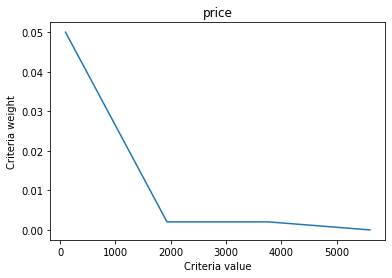

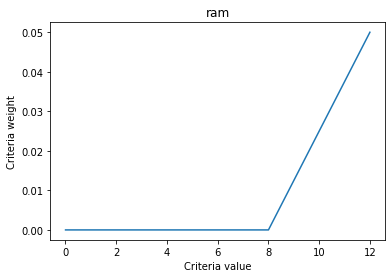

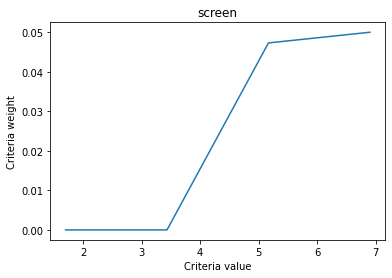

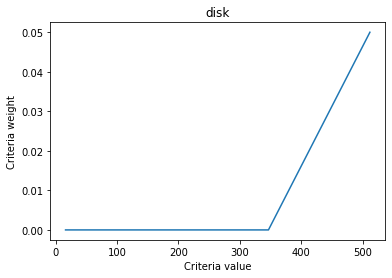

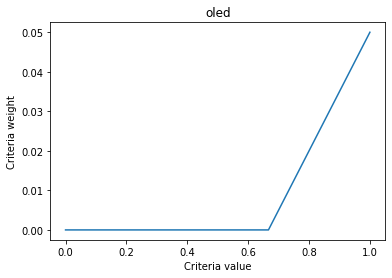

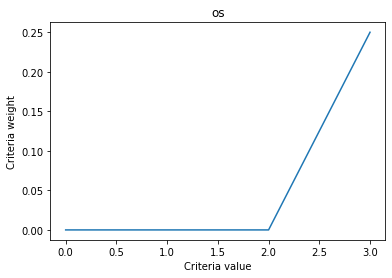

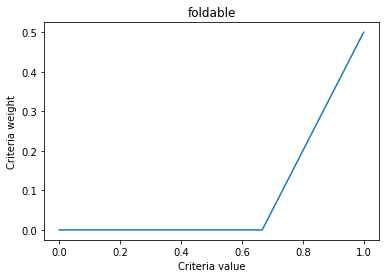

In [27]:
for u in U:
    u.plot()

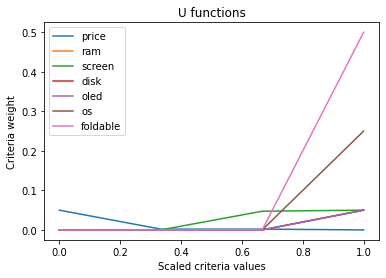

In [28]:
U.plot()

For binary criteria more than 2 breakpoints are unnecessary, as they only use the 2 marginal values.

What is interesting is the low weight of the price criteria and the fact that according to UTA the most important criteria is if the phone is foldable.

## AHP

In this section the alternatives are ranked using the AHP method. The criteria are placed in a hierarchy, with the lowest level being alterantives and higher levels being more abstract.

In [29]:
class Node:
    def __init__(self,value,children):
        self.children = children
        self.value = value
        n = len(children)
        self.n = n
        self._comparisons = np.ones((n,n))
        self.weights = np.ones(n)
        self.lambda_max = None
    
    @property
    def comparisons(self):
        return self._comparisons

    @comparisons.setter
    def comparisons(self,comps):
        self._comparisons = np.array(comps)

    def draw(self,graph=None,parent=None):
        if graph == None:
            graph = nx.DiGraph()
        graph.add_node(self.value)
        if parent != None:
            graph.add_edge(parent,self.value)
        for child in self.children:
            child.draw(graph,self.value)
        if parent == None:
            plt.figure(3,figsize=(12,12)) 
            pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")
            nx.draw(graph,pos, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_color='black')
            plt.show()

    def isLeaf(self):
        return len(self.children) == 0

    def calc_weights(self,power=10):
        if self.n == 0:
            return None

        lambs,eigvec = np.linalg.eig(self.comparisons)
        #principal = eigvec[np.argmax(lambs)] #shenanigans with complex number

        # using power method
        ape = np.linalg.matrix_power(self.comparisons,power) @ np.ones(self.n)
        self.weights = ape/np.sum(ape)
        self.lambda_max = np.abs(np.max(lambs))
    
    def reconstruct_weights(self):
        if type(self.weights) == None:
            self.calc_weights()
        
        self.reconstructed = np.ones((self.n,self.n))

        for i,w_i in enumerate(self.weights):
            for j,w_j in enumerate(self.weights[i+1:],i+1):
                self.reconstructed[i,j] = w_i/w_j
                self.reconstructed[j,i] = w_j/w_i
    
    def show_differences(self):
        dif = self.reconstructed - self.comparisons
        norm = mcolors.CenteredNorm(0)
        plt.xticks(np.arange(0, self.n, 1))
        plt.yticks(np.arange(0, self.n, 1))
        plt.imshow(dif,cmap="seismic",norm=norm,interpolation="nearest")
        plt.colorbar()
        plt.show()
    
    def consistency_index(self):
        assert self.lambda_max != None
        return np.around((self.lambda_max - self.n)/(self.n -1),4)
    
    def isConsistent(self):
        return self.consistency_index() == 0

    def __call__(self,value):
        _sum = 0
        if self.value == value:
            return 1
        
        for w,child in zip(self.weights,self.children):
            _sum += w*child(value)
        return _sum

    def __repr__(self):
        return f"Node {self.value}"

### Hierarchy

Screen and oled are grouped into the same criteria called Display. Disk and Ram are grouped into Memory, similarily Foldable and OS are put into Details.

These 3 groups together with price are the highest levels in the hierarchy, directly contributing to the goal function.

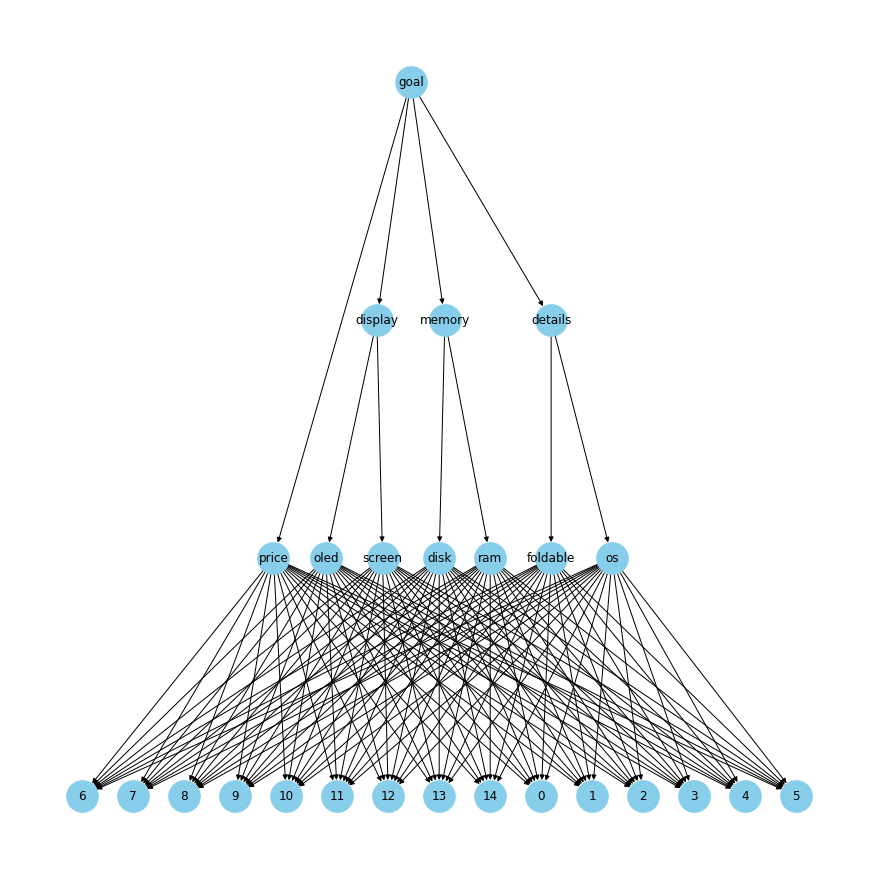

In [30]:
alternatives = [Node(i,[]) for i in range(len(data))]

nodes = dict([(crit,Node(crit,alternatives))for crit in data])

crit_cat = [Node("display",[nodes["screen"],nodes["oled"]]),
            Node("memory",[nodes["ram"],nodes["disk"]]),
            Node("details",[nodes["os"],nodes["foldable"]])]

for node in crit_cat + alternatives:
    nodes[node.value] = node

goal = Node("goal",crit_cat + [nodes["price"]])

nodes["goal"] = goal

goal.draw()

Here the pairwise comparisons of each level are provided. They describe how many times some criterion is valued in comparison to another one.

In [31]:
# should be inconsistent
nodes["goal"].comparisons = [[1,0.5,0.5,0.1],
                            [2,1,0.5,0.1],
                            [2,2,1,0.8],
                            [10,10,1.25,1]]

# inconsistent on purpose, its hard to mess up a 2x2
nodes["display"].comparisons =([[1,0.2],
                                [3,1]])

nodes["memory"].comparisons = [[1,2],
                                [0.5,1]]

nodes["details"].comparisons = [[1,10],
                                [0.1,1]]

Because the data gives the raw values of criteria for alternatives, the lowest level of preferences can be directly calculated from them.

In [32]:
def calc_comparisons(data:pd.DataFrame,isGain:List[bool],nodes:Dict[Hashable,Node]):
    n = len(data)

    def safe_div(a,b):
        return a/b if a != 0 and b != 0 else (a+1)/(b+1)

    for crit_i,crit in enumerate(data):
        comparisons = np.ones((n,n))
        for i,row_i in enumerate(data.iloc):
            for j,row_j in enumerate(data.iloc[i+1:].iloc,i+1): #in range(i+1,len(data)):
                #row_j = data.iloc[j]
                div = safe_div(row_i[crit],row_j[crit])
                if not isGain[crit_i]:
                    div = 1/div
                comparisons[i,j] = div
                comparisons[j,i] = 1/div
        nodes[crit].comparisons = comparisons


In [33]:
calc_comparisons(data,crit_types,nodes)

Here the whole AHP procedure is performed. The weights are calculated and if the matrix is not consistent it is reconstructed using the newly calculated weights. In such case the differences between the new matrics and the old one are displayed.

To calculate relative consitency indexes, so called random indexes are needed. These are the average constitency indexes for matrices of different sizes.

In [34]:
random_index = [0,0,0.58,0.9,1.12,1.24,1.32,1.41,1.45,1.49,1.51,1.48,1.56,1.57,1.58]

Yap, Jeremy & Ho, Chiung Ching & Yee, Ting. (2017). Analytic Hierarchy Process (AHP) for business site selection. AIP Conference Proceedings. 2016. 10.1063/1.5055553. 

---------------
Node price
Weights
[(0, 0.03), (1, 0.06), (2, 0.01), (3, 0.02), (4, 0.01), (5, 0.02), (6, 0.01), (7, 0.02), (8, 0.17), (9, 0.03), (10, 0.02), (11, 0.5), (12, 0.05), (13, 0.03), (14, 0.03)]

Consistency index: 0.0
Relative Consistency index: 0.0
---------------
Node ram
Weights
[(0, 0.06), (1, 0.04), (2, 0.06), (3, 0.04), (4, 0.08), (5, 0.08), (6, 0.08), (7, 0.08), (8, 0.04), (9, 0.08), (10, 0.08), (11, 0.0), (12, 0.06), (13, 0.12), (14, 0.06)]

Consistency index: 0.0
Relative Consistency index: 0.0
---------------
Node screen
Weights
[(0, 0.07), (1, 0.07), (2, 0.08), (3, 0.07), (4, 0.08), (5, 0.08), (6, 0.08), (7, 0.07), (8, 0.03), (9, 0.07), (10, 0.07), (11, 0.02), (12, 0.07), (13, 0.07), (14, 0.08)]

Consistency index: 0.0
Relative Consistency index: 0.0
---------------
Node disk
Weights
[(0, 0.05), (1, 0.02), (2, 0.05), (3, 0.02), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.05), (9, 0.05), (10, 0.05), (11, 0.01), (12, 0.05), (13, 0.2), (14, 0.05)]

Consistency inde

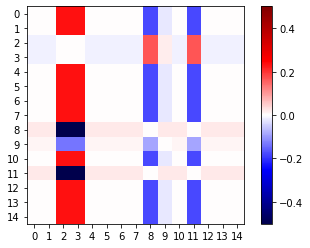

---------------
Node foldable
Weights
[(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.1), (5, 0.1), (6, 0.1), (7, 0.1), (8, 0.1), (9, 0.05), (10, 0.05), (11, 0.05), (12, 0.05), (13, 0.05), (14, 0.05)]

Consistency index: -0.0
Relative Consistency index: -0.0
---------------
Node display
Weights
[('screen', 0.21), ('oled', 0.79)]

Consistency index: -0.2254
Relative Consistency index: -0.2254


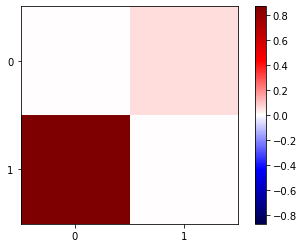

---------------
Node memory
Weights
[('ram', 0.67), ('disk', 0.33)]

Consistency index: 0.0
Relative Consistency index: 0.0
---------------
Node details
Weights
[('os', 0.91), ('foldable', 0.09)]

Consistency index: 0.0
Relative Consistency index: 0.0
---------------
Node goal
Weights
[('display', 0.07), ('memory', 0.1), ('details', 0.24), ('price', 0.59)]

Consistency index: 0.1034
Relative Consistency index: 0.11488888888888889


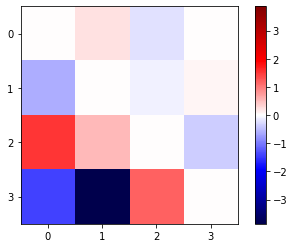

In [35]:
def safe_div(a,b):
    if b == 0:
        return a
    else:
        return a/b

for node in nodes.values():
    if node.isLeaf():
        continue
    print("-"*15)
    print(node)

    node.calc_weights()
    print("Weights")
    children = [child.value for child in node.children]
    print(f"{list(zip(children,np.around(node.weights,2)))}")
    
    #print(f"lambda max: {node.lambda_max}")
    print(f"")
    ci = node.consistency_index() 
    print(f"Consistency index: {ci}")
    print(f"Relative Consistency index: {safe_div(ci,random_index[node.n-1])}")
    if node.isConsistent():
        continue

    node.reconstruct_weights()
    node.show_differences()

For all inconstistent matrices the relative consistency index is rather low, so the preferential information should be maintained.

The biggest difference appears in the Display matrix, however fixing it would be trivial as it consists of 2 values.

For almost all criteria the matrices of alternatives comparison are consistent. The only exception is with the os criteria, where 0 appears and the difference appears because of the way 0 is handled during the division (adding 1 to both nominator and denominator when either is 0).

## Results

In this section ranking are constructed based on the values obtained with the UTA and AHP methods. These are also compared with PROMETHEE II results from the previous report.

To compare the ranking Kendall's $\tau$ Coeffictient is used.

In [36]:
def kendall_dist(t1,t2):
    m = len(t1)
    return 0.5 * sum([(t1[i] < t1[j] and t2[i] > t2[j]) or (t1[i] > t1[j] and t2[i] < t2[j]) for i in range(m) for j in range(m)])

def kendall_tau(t1,t2):
    m = len(t1)
    return 1 - (4*kendall_dist(t1,t2)/(m*(m-1)))

In [37]:
estimated_weights = [9,4,2,3,5,8,6]
crit_discrimination = [
    #p,q
	[500,100],
	[4,2],
	[0.5,0.1],
	[64,16],
	[0,0],
	[2,0],
	[0,0]
]
prom2ranker = Promethee2(data,crit_types,estimated_weights,crit_discrimination)
prom2ranker.rank()
prom2_rank = prom2ranker.flipped_ranking()
print("PROMETHEE II ranking")
print(str(prom2ranker))


PROMETHEE II ranking
rank  | name                           | id   
0     | Xiaomi Poco X6 Pro             | 13   
1     | Motorola Razr 8                | 7    
2     | Samsung Galaxy M34             | 12   
3     | Motorola Razr 40               | 5    
4     | Motorola Razr Ultra            | 4    
5     | Lg V60                         | 14   
6     | Nokia 2660 Flip                | 8    
7     | Samsung Galaxy Z Flip 5        | 6    
8     | Samsung Galaxy A55             | 10   
9     | Huawei P30                     | 0    
10    | Huawei P40                     | 9    
11    | Huawei P20 Lite                | 1    
12    | Nokia 3310                     | 11   
13    | Iphone 15                      | 2    
14    | Iphone 12                      | 3    



In [38]:
uta_values = [U(*data.iloc[i]).value() for i in range(len(data))]
uta_rank = tuple(reversed(np.argsort(uta_values)))
print("UTA values")
print(*np.around(uta_values,2))
print()
print("UTA ranking")
show_rank(uta_rank,data.index)
uta_rank = flip_rank(uta_rank)

UTA values
0.36 0.33 0.1 0.1 0.85 0.85 0.85 0.85 0.59 0.1 0.35 0.05 0.38 0.46 0.36

UTA ranking
rank  | name                           | id   
0     | Motorola Razr 40               | 5    
1     | Motorola Razr Ultra            | 4    
2     | Motorola Razr 8                | 7    
3     | Samsung Galaxy Z Flip 5        | 6    
4     | Nokia 2660 Flip                | 8    
5     | Xiaomi Poco X6 Pro             | 13   
6     | Samsung Galaxy M34             | 12   
7     | Lg V60                         | 14   
8     | Huawei P30                     | 0    
9     | Samsung Galaxy A55             | 10   
10    | Huawei P20 Lite                | 1    
11    | Huawei P40                     | 9    
12    | Iphone 12                      | 3    
13    | Iphone 15                      | 2    
14    | Nokia 3310                     | 11   



In UTA it is clear that foldability is the most important criteria, having a weight of over 50%. Some of the other criteria all weight the minimum threshold.

In [39]:
ahp_values = [nodes["goal"](i) for i in range(len(data))]
ahp_rank = tuple(reversed(np.argsort(ahp_values)))
print("AHP values")
print(*np.around(ahp_values,2))
print()
print("AHP ranking")
show_rank(ahp_rank,data.index)
ahp_rank = flip_rank(ahp_rank)

AHP values
0.05 0.06 0.02 0.03 0.04 0.04 0.04 0.05 0.12 0.04 0.05 0.31 0.06 0.06 0.05

AHP ranking
rank  | name                           | id   
0     | Nokia 3310                     | 11   
1     | Nokia 2660 Flip                | 8    
2     | Samsung Galaxy M34             | 12   
3     | Huawei P20 Lite                | 1    
4     | Xiaomi Poco X6 Pro             | 13   
5     | Lg V60                         | 14   
6     | Huawei P30                     | 0    
7     | Samsung Galaxy A55             | 10   
8     | Motorola Razr 8                | 7    
9     | Motorola Razr 40               | 5    
10    | Motorola Razr Ultra            | 4    
11    | Huawei P40                     | 9    
12    | Samsung Galaxy Z Flip 5        | 6    
13    | Iphone 12                      | 3    
14    | Iphone 15                      | 2    



In AHP price is the most important criteria, which is the result of the first comparison matrix. As a result the cheapest phones are very high in the ranking.

Here the rankings are compared using the Kendalls $\tau$ coefficient.

In [40]:
print("Kendall tau between UTA and AHP",kendall_tau(uta_rank,ahp_rank))

Kendall tau between UTA and AHP 0.04761904761904767


Overall the UTA and AHP rank are the most distanced from each other which can be seen when comparing them.

In [41]:
print("Kendall tau between UTA and PROMETHEE II",kendall_tau(prom2_rank,uta_rank))

Kendall tau between UTA and PROMETHEE II 0.638095238095238


The PROMETHEE II and UTA rankings are quite similar, however there are visible differences.

In [42]:
print("Kendall tau between AHP and PROMETHEE II",kendall_tau(ahp_rank,prom2_rank))

Kendall tau between AHP and PROMETHEE II 0.18095238095238098


Seems like AHP is the farthest of the 3, however it is more similar to PROMETHEE II than UTA